# HAR CNN training 

In [1]:
# Imports
import numpy as np
import os
from utils.semg_utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [2]:
path = os.path.abspath(os.getcwd())
X_train, labels_train, list_ch_train, X_test, labels_test, list_ch_test = read_data(data_path= path + os.sep + "sEMG" + os.sep + "Database 2" + os.sep)

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [3]:
# Normalize?
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [4]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 123)

One-hot encoding:

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [6]:
# Imports
import tensorflow as tf

### Hyperparameters

In [7]:
batch_size = 100       # Batch size
seq_len = 2496          # Number of steps
learning_rate = 0.00001
epochs = 200

n_classes = 6
n_channels = 2

### Construct the graph
Placeholders

In [8]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layers

Note: Should we use a different activation? Like tf.nn.tanh?

In [9]:
with graph.as_default():
    # (batch, 2496, 2) --> (batch, 1248, 4)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=4, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 1248, 4) --> (batch, 624, 8)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=8, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 624, 8) --> (batch, 312, 16)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=16, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 312, 16) --> (batch, 156, 32)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=32, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
    
    # (batch, 156, 32) --> (batch, 78, 64)
    conv5 = tf.layers.conv1d(inputs=max_pool_4, filters=64, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_5 = tf.layers.max_pooling1d(inputs=conv5, pool_size=2, strides=2, padding='same')
    
    # (batch, 78, 64) --> (batch, 39, 128)
    conv6 = tf.layers.conv1d(inputs=max_pool_5, filters=128, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_6 = tf.layers.max_pooling1d(inputs=conv6, pool_size=2, strides=2, padding='same')
    

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


Now, flatten and pass to the classifier

In [10]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_6, (-1, 128 * 39))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



### Train the network

In [11]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [12]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 0/200 Iteration: 5 Train loss: 1.807647 Train acc: 0.140000
Epoch: 1/200 Iteration: 10 Train loss: 1.777870 Train acc: 0.190000
Epoch: 1/200 Iteration: 10 Validation loss: 1.792212 Validation acc: 0.180000
Epoch: 2/200 Iteration: 15 Train loss: 1.792846 Train acc: 0.190000
Epoch: 3/200 Iteration: 20 Train loss: 1.761654 Train acc: 0.260000
Epoch: 3/200 Iteration: 20 Validation loss: 1.787570 Validation acc: 0.180000
Epoch: 4/200 Iteration: 25 Train loss: 1.770509 Train acc: 0.250000
Epoch: 4/200 Iteration: 30 Train loss: 1.771861 Train acc: 0.180000
Epoch: 4/200 Iteration: 30 Validation loss: 1.783134 Validation acc: 0.185000
Epoch: 5/200 Iteration: 35 Train loss: 1.786848 Train acc: 0.170000
Epoch: 6/200 Iteration: 40 Train loss: 1.767429 Train acc: 0.230000
Epoch: 6/200 Iteration: 40 Validation loss: 1.778891 Validation acc: 0.200000
Epoch: 7/200 Iteration: 45 Train loss: 1.793062 Train acc: 0.150000
Epoch: 8/200 Iteration: 50 Train loss: 1.764955 Train acc: 0.250000
Epoch: 8/

Epoch: 64/200 Iteration: 385 Train loss: 1.652834 Train acc: 0.260000
Epoch: 64/200 Iteration: 390 Train loss: 1.618681 Train acc: 0.260000
Epoch: 64/200 Iteration: 390 Validation loss: 1.682328 Validation acc: 0.235000
Epoch: 65/200 Iteration: 395 Train loss: 1.639008 Train acc: 0.270000
Epoch: 66/200 Iteration: 400 Train loss: 1.649752 Train acc: 0.240000
Epoch: 66/200 Iteration: 400 Validation loss: 1.680088 Validation acc: 0.235000
Epoch: 67/200 Iteration: 405 Train loss: 1.685731 Train acc: 0.190000
Epoch: 68/200 Iteration: 410 Train loss: 1.650534 Train acc: 0.240000
Epoch: 68/200 Iteration: 410 Validation loss: 1.677845 Validation acc: 0.240000
Epoch: 69/200 Iteration: 415 Train loss: 1.664252 Train acc: 0.240000
Epoch: 69/200 Iteration: 420 Train loss: 1.603226 Train acc: 0.260000
Epoch: 69/200 Iteration: 420 Validation loss: 1.675583 Validation acc: 0.240000
Epoch: 70/200 Iteration: 425 Train loss: 1.630283 Train acc: 0.220000
Epoch: 71/200 Iteration: 430 Train loss: 1.643621 

Epoch: 126/200 Iteration: 760 Train loss: 1.561234 Train acc: 0.320000
Epoch: 126/200 Iteration: 760 Validation loss: 1.577484 Validation acc: 0.270000
Epoch: 127/200 Iteration: 765 Train loss: 1.590549 Train acc: 0.200000
Epoch: 128/200 Iteration: 770 Train loss: 1.512694 Train acc: 0.310000
Epoch: 128/200 Iteration: 770 Validation loss: 1.573640 Validation acc: 0.270000
Epoch: 129/200 Iteration: 775 Train loss: 1.572634 Train acc: 0.350000
Epoch: 129/200 Iteration: 780 Train loss: 1.475151 Train acc: 0.350000
Epoch: 129/200 Iteration: 780 Validation loss: 1.569695 Validation acc: 0.280000
Epoch: 130/200 Iteration: 785 Train loss: 1.519334 Train acc: 0.300000
Epoch: 131/200 Iteration: 790 Train loss: 1.528352 Train acc: 0.300000
Epoch: 131/200 Iteration: 790 Validation loss: 1.565685 Validation acc: 0.280000
Epoch: 132/200 Iteration: 795 Train loss: 1.565740 Train acc: 0.230000
Epoch: 133/200 Iteration: 800 Train loss: 1.530930 Train acc: 0.290000
Epoch: 133/200 Iteration: 800 Validat

Epoch: 187/200 Iteration: 1125 Train loss: 1.399365 Train acc: 0.410000
Epoch: 188/200 Iteration: 1130 Train loss: 1.330843 Train acc: 0.510000
Epoch: 188/200 Iteration: 1130 Validation loss: 1.395766 Validation acc: 0.485000
Epoch: 189/200 Iteration: 1135 Train loss: 1.399923 Train acc: 0.520000
Epoch: 189/200 Iteration: 1140 Train loss: 1.293825 Train acc: 0.530000
Epoch: 189/200 Iteration: 1140 Validation loss: 1.389954 Validation acc: 0.490000
Epoch: 190/200 Iteration: 1145 Train loss: 1.343659 Train acc: 0.520000
Epoch: 191/200 Iteration: 1150 Train loss: 1.352073 Train acc: 0.480000
Epoch: 191/200 Iteration: 1150 Validation loss: 1.384086 Validation acc: 0.500000
Epoch: 192/200 Iteration: 1155 Train loss: 1.393610 Train acc: 0.440000
Epoch: 193/200 Iteration: 1160 Train loss: 1.311744 Train acc: 0.520000
Epoch: 193/200 Iteration: 1160 Validation loss: 1.378189 Validation acc: 0.500000
Epoch: 194/200 Iteration: 1165 Train loss: 1.376629 Train acc: 0.520000
Epoch: 194/200 Iteration

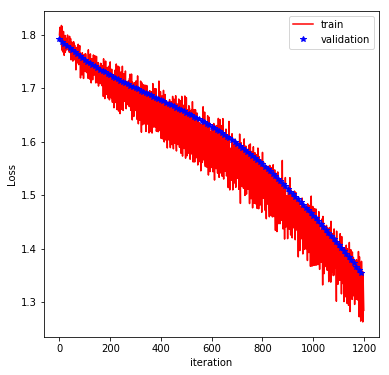

In [13]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

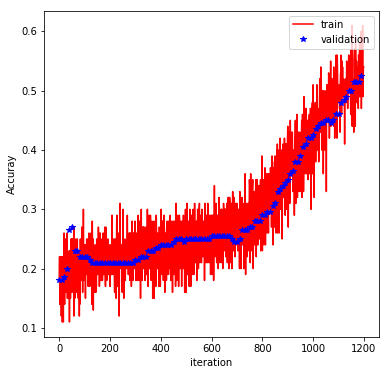

In [14]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [24]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        print(y_t)
        print(sess.run(tf.argmax(logits, 1), feed_dict=feed))
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        print(batch_acc)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))
    


INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
[[0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0

[0 1 0 4 4 5 1 4 5 0 0 1 4 5 5 5 5 5 4 5 0 4 1 1 4 0 1 5 0 4 5 5 1 0 5 4 4
 1 0 0 1 5 4 1 0 5 0 5 5 5 1 0 5 0 5 4 1 0 4 0 4 5 5 1 1 5 0 1 5 1 4 4 5 5
 1 1 4 5 5 1 4 5 1 1 4 5 4 0 5 1 0 1 5 5 5 2 2 0 0 4]
0.49
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 

0.58
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 